# Bayesian Survival Analysis

Database: https://github.com/ludovicbenistant/Management-Analytics/tree/master/Supply%20Chain/Maintenance%20(survival%20analysis) 

Normal survival analysis done using the same data: https://rpubs.com/Ludovicbenistant/predictive-maintenance 

Pymc3 code explanation: https://pymc-devs.github.io/pymc3/notebooks/survival_analysis.html 

In [55]:
%matplotlib inline
# Import
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as T
import pandas as pd
# load dataset
## Let's take only the first 100 rows
df = pd.read_csv('maintenance_data.csv', sep=';',nrows = 100)
df = df[df['team'].isin(['TeamA', 'TeamC'])]
df.head(10)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
5,30,0,87.678801,115.712262,89.792105,TeamA,Provider1
9,81,1,99.178235,99.138717,95.492965,TeamC,Provider4
11,29,0,67.812251,96.107846,122.371809,TeamA,Provider1
12,65,1,86.366111,92.561972,96.667950,TeamA,Provider3
13,65,1,76.144654,93.973454,108.944273,TeamA,Provider3
14,82,1,103.107263,103.673197,79.504532,TeamC,Provider4


In [56]:
# % of broken machines
df.broken.mean()

0.38095238095238093

In [57]:
# Prepare the data
df.broken = df.broken.astype(np.int64)
df.team = (df.team == 'TeamA').astype(np.int64)
n_machines = df.shape[0]
machine = np.arange(n_machines)
df.head(10)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,1,Provider4
1,81,1,72.075938,103.065701,87.271062,0,Provider4
2,60,0,96.272254,77.801376,112.196170,1,Provider1
3,86,1,94.406461,108.493608,72.025374,0,Provider2
5,30,0,87.678801,115.712262,89.792105,1,Provider1
9,81,1,99.178235,99.138717,95.492965,0,Provider4
11,29,0,67.812251,96.107846,122.371809,1,Provider1
12,65,1,86.366111,92.561972,96.667950,1,Provider3
13,65,1,76.144654,93.973454,108.944273,1,Provider3
14,82,1,103.107263,103.673197,79.504532,0,Provider4


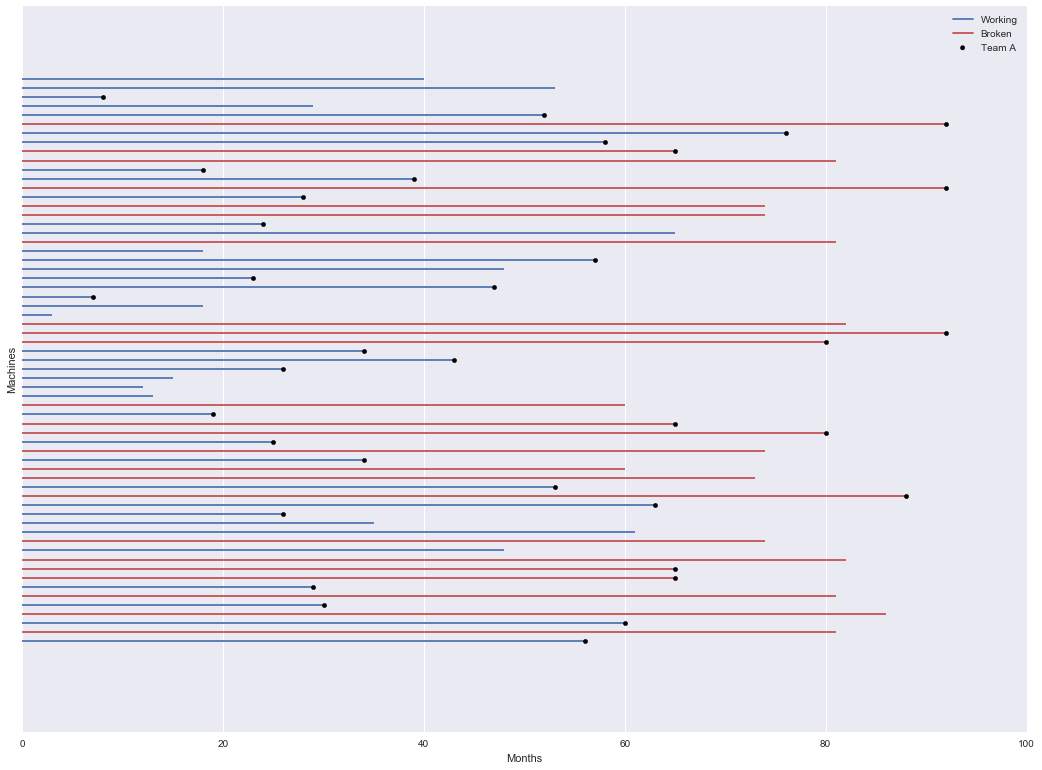

In [58]:
# First plot of our data
fig, ax = plt.subplots(figsize=(18, 13))
blue, _, red = sns.color_palette()[:3]

ax.hlines(machine[df.broken.values == 0], 0, df[df.broken.values == 0].lifetime,
          color=blue, label='Working')

ax.hlines(machine[df.broken.values == 1], 0, df[df.broken.values == 1].lifetime,
          color=red, label='Broken')

ax.scatter(df[df.team.values == 1].lifetime, machine[df.team.values == 1],
          color='k', zorder=10, label='Team A')

ax.set_xlim(left=0)
ax.set_xlabel('Months')
ax.set_yticks([])
ax.set_ylabel('Machines')
#ax.set_ylim(-0.25, n_machines + 0.25)
ax.legend(loc='upper right');


In [59]:
# Second plot to have a glance of the data
interval_length = 3
interval_bounds = np.arange(0, df.lifetime.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

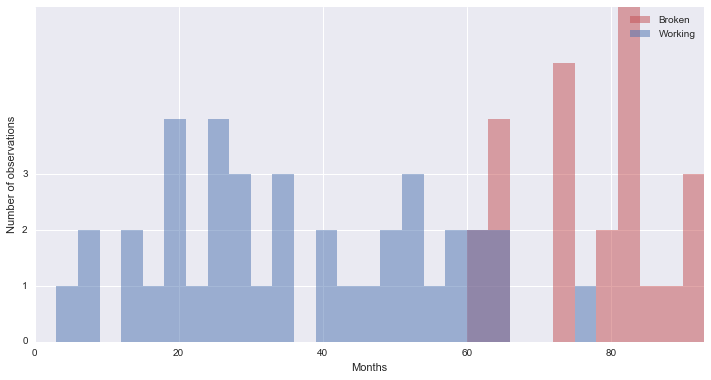

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(df[df.broken == 1].lifetime.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Broken');
ax.hist(df[df.broken == 0].lifetime.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Working');

ax.set_xlim(0, interval_bounds[-1]);
ax.set_xlabel('Months');

ax.set_yticks([0, 1, 2, 3]);
ax.set_ylabel('Number of observations');

ax.legend();

In [61]:
last_period = np.floor((df.lifetime - 0.01) / interval_length).astype(int)

death = np.zeros((n_machines, n_intervals))
death[machine, last_period] = df.broken

In [62]:
exposure = np.greater_equal.outer(df.lifetime, interval_bounds[:-1]) * interval_length
exposure[machine, last_period] = df.lifetime - interval_bounds[last_period]

In [63]:
SEED = 5078864 # from random.org
with pm.Model() as model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sd=1000)

    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.team), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)
    

In [64]:
n_samples = 1000
with model:
    trace_ = pm.sample(n_samples,random_seed=SEED)
#   trace_ = pm.sample_init(draws=500, n_init=2000)


Average ELBO = -926.31:  20%|█▉        | 39052/200000 [00:06<00:26, 6096.41it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "//anaconda/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "//anaconda/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "//anaconda/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]


In [69]:
trace = trace_[100:]

In [70]:
np.exp(trace['beta'].mean())

0.46445276400154134

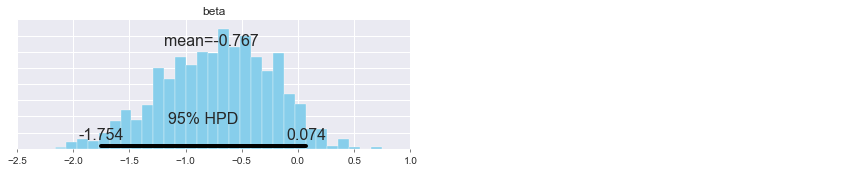

In [71]:
pm.plot_posterior(trace, varnames=['beta'], color='#87ceeb');

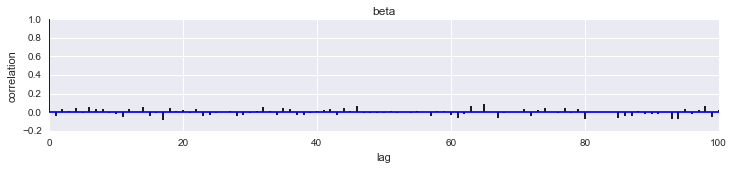

In [72]:
pm.autocorrplot(trace, varnames=['beta']);

In [73]:
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [74]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [75]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

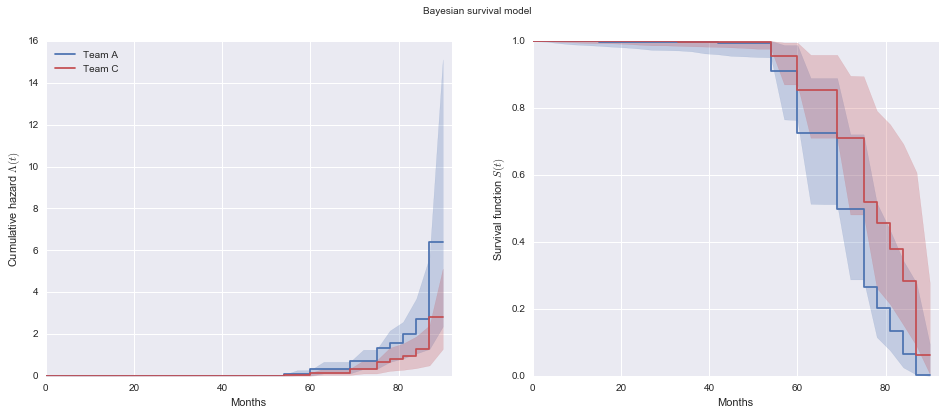

In [83]:
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))

plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
              hazard_ax, color=blue, label='Team A')
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='Team C')

hazard_ax.set_xlim(0, df.lifetime.max());
hazard_ax.set_xlabel('Months');

hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

hazard_ax.legend(loc=2);

plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)

surv_ax.set_xlim(0, df.lifetime.max());
surv_ax.set_xlabel('Months');

surv_ax.set_ylabel('Survival function $S(t)$');

fig.suptitle('Bayesian survival model');

### Time varying effects


In [77]:
with pm.Model() as time_varying_model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    beta = GaussianRandomWalk('beta', tau=1., shape=n_intervals)

    lambda_ = pm.Deterministic('h', lambda0 * T.exp(T.outer(T.constant(df.team), beta)))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

In [78]:
with time_varying_model:
    time_varying_trace_ = pm.sample(n_samples, random_seed=SEED)

100%|██████████| 1000/1000 [05:51<00:00,  2.85it/s]


In [79]:
time_varying_trace = time_varying_trace_[100:]

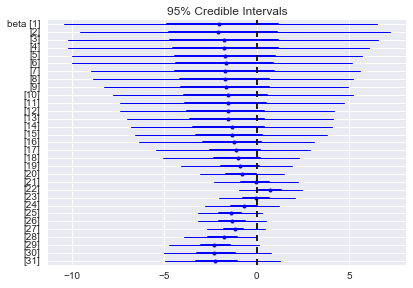

In [80]:
pm.forestplot(time_varying_trace, varnames=['beta']);

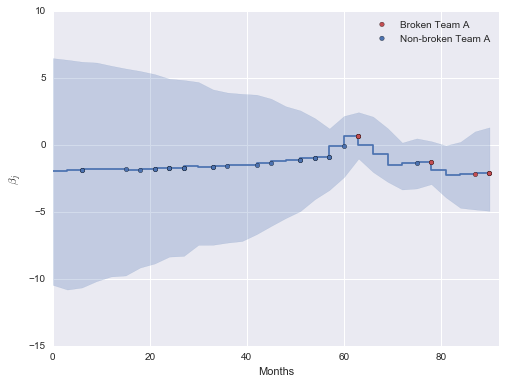

In [84]:
fig, ax = plt.subplots(figsize=(8, 6))

beta_hpd = np.percentile(time_varying_trace['beta'], [2.5, 97.5], axis=0)
beta_low = beta_hpd[0]
beta_high = beta_hpd[1]
ax.fill_between(interval_bounds[:-1], beta_low, beta_high,
                color=blue, alpha=0.25);
beta_hat = time_varying_trace['beta'].mean(axis=0)
ax.step(interval_bounds[:-1], beta_hat, color=blue);
ax.scatter(interval_bounds[last_period[(df.broken.values == 1) & (df.team == 1)]],
           beta_hat[last_period[(df.broken.values == 1) & (df.team == 1)]],
           c=red, zorder=10, label='Broken Team A');
ax.scatter(interval_bounds[last_period[(df.broken.values == 0) & (df.team == 1)]],
           beta_hat[last_period[(df.broken.values == 0) & (df.team == 1)]],
           c=blue, zorder=10, label='Non-broken Team A');

ax.set_xlim(0, df.lifetime.max());
ax.set_xlabel('Months');

ax.set_ylabel(r'$\beta_j$');

ax.legend();

In [85]:
tv_base_hazard = time_varying_trace['lambda0']
tv_met_hazard = time_varying_trace['lambda0'] * np.exp(np.atleast_2d(time_varying_trace['beta']))

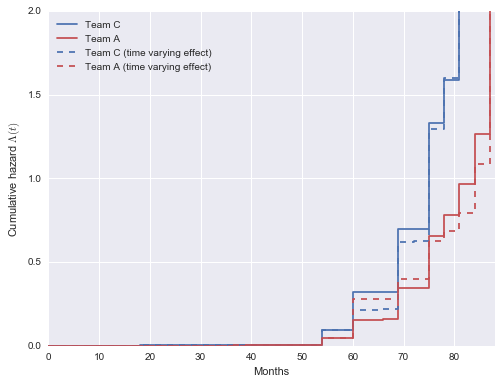

In [86]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.step(interval_bounds[:-1], cum_hazard(base_hazard.mean(axis=0)),
        color=blue, label='Team C');
ax.step(interval_bounds[:-1], cum_hazard(met_hazard.mean(axis=0)),
        color=red, label='Team A');

ax.step(interval_bounds[:-1], cum_hazard(tv_base_hazard.mean(axis=0)),
        color=blue, linestyle='--', label='Team C (time varying effect)');
ax.step(interval_bounds[:-1], cum_hazard(tv_met_hazard.mean(axis=0)),
        color=red, linestyle='--', label='Team A (time varying effect)');

ax.set_xlim(0, df.lifetime.max() - 4);
ax.set_xlabel('Months');

ax.set_ylim(0, 2);
ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$');

ax.legend(loc=2);

Database: https://github.com/ludovicbenistant/Management-Analytics/tree/master/Supply%20Chain/Maintenance%20(survival%20analysis) 

Normal survival analysis done with the same data (for comparison purposes): https://rpubs.com/Ludovicbenistant/predictive-maintenance 

Pymc3 code explanation: https://pymc-devs.github.io/pymc3/notebooks/survival_analysis.html 